ESTIMATE TOTAL MEMORY USAGE: 1000 MB (1600 MB peak)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# Goals of this notebook

* Build our first classification model and evaluate it on the hold-out sets.

* Try various features and understand what the model is doing.

Note: this is a very long notebook and we don't expect you to go through it in a couple of hours. Neither is the process followed below exhaustive. Play around, change things and most importantly, enjoy yourself.

**Notes**: You can install extensions (google for nbextensions) with Jupyter notebooks. I tend to use resuse to display memory usage in the top right corner which really helps.

To run a cell, press: "Shift + Enter"

To add a cell before your current cell, press: "Esc + a"

To add a cell after your current cell, press: "Esc + b"

To delete a cell, press: "Esc + x"

To be able to edit a cell, press: "Enter"

To see more documentation about of a function, type ?function_name

To see source code, type ??function_name

To quickly see possible arguments for a function, type "Shift + Tab" after typing the function name.

Esc and Enter take you into different modes. Press "Esc + h" to see all shortcuts.

### Read in data from previous day

In [3]:
DATA_PATH = "../data/walmart"
TRAIN_PATH = f"{DATA_PATH}/train.csv"
TEST_PATH = f"{DATA_PATH}/test.csv"

In [4]:
df_train = pd.read_feather(f'{DATA_PATH}/df_raw_train.feather')
df_val = pd.read_feather(f'{DATA_PATH}/df_raw_val.feather')
df_test = pd.read_feather(f'{DATA_PATH}/df_raw_test.feather')

### Modeling

The main technique we'll use today is **Logistic Regression**. Logistic regression is *not* a regression model - it is a classification model.

A quick summary:

Given n features - $x_1, x_2, \ldots, x_n$, and a binary target variable - $y \in {0,1}$, logistic regression predicts the probability this example belongs to class 1 as:

$$p = \sigma(w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n)$$

where $\sigma$ is the sigmoid function: $\sigma(x) = \frac{1}{1 + e^{-x}}$

As we discussed in the lecture, you can think of $\sigma$ as a softer switch function which "smoothifies" the discrete switch:

$s(x) = 
\begin{cases}
0, \text{ if x < 0} \\
1, \text{ if x} \geq 0
\end{cases}
$

This is a linear model since it uses the linear combination:

$$w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n$$

In particular, this means that we don't take into account features like $x_i x_j$ or higher-order terms. If we do want to take those into account, we would have to explicitly create a feature (column) $x_i x_j$.

# Featurization Strategy 1:

We want to predict the trip type of each VisitNumber. Our hypothesis is that one of the simplest predictors is the type of items bought on each trip. But we have several rows for each trip. How can we create a dataset with one row per visit and a description of all the items bought.

The first question is whether we should use Upc, FinelineNumber or DepartmentDescription to describe what items were bought.

**Question**: What are the tradeoffs between choosing each one of these 3 options?

**Answer**:

So how exactly do we create rows that have some description of the departments someone shopped at. One easy way is to have a column for every unique department and a row for each visit number. The entry in row i and column j is the number of items bought during visit i in department j.

**Question**: Can you think of an easy way to create this table using one of the in-build pandas functions we have seen?

We see a bunch of nans in case a visit didn't buy products from a certain department. We should replace these nans by 0. You should also do the same thing with the validation and test datasets.

In [6]:
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

In [7]:
df_train_f1.head(2)

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


It is always a good idea to check if these numbers are sensible. As a data scientist, it is good to be extremely skeptical of procedures where a lot of data is being transformed into a lot of some other data without fine-grained checks. 

**Question**: Can you think of some checks to do on df_train_f1 and df_train to ensure the correct thing is being done.

There is a discrepancy for visit number 8. Let's check why.

Aha! we can immediately see what causes the discrepancy. We have NaNs in Upc and FinelineNumber. In other words, there are items that weren't classified correctly. Let's see how much of a problem this is.

We could fill nulls with the value 0 (for convenience). Let's ensure none of the existing columns have 0s so we don't merge value = 0 with null values

Well so we can't use 0 as a stand-in value for null in FinelineNumber because we would be mixing the category where FinelineNumber is actually 0 with ones where FinelineNumber is null. Let's try -1.

Try constructing the pivot table again. Does our test pass?

In [24]:
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

In [25]:
(df_train_f1.sum(axis=1) - df_train.groupby('VisitNumber').agg({'ScanCount': np.sum})['ScanCount']).sum()

0.0

Perfect!! The counts agree completely between the pivot table and the group by. We only caught this bug because pd.pivot_table was dropping the null columns (DepartmentDescription is null) while the group by was only looking at VisitNumbers and not dropping any rows. It's generally a good idea to check for nulls after reading in the data.

**Question**: Can you foresee something else that can go wrong here? (Hint: look at the dimensions of each dataframe)

**Answer**: 

**Question**: Why would different dimensions in train vs val vs test be a problem? You can think of a linear model to make the problem more concrete.

**Answer**:

**Question**: Find out which column is missing.

Our goal is to make predictions on the true Kaggle test. If we use the distribution of number of products bought by department, then it's possible that there are departments in the test set that are not in the train set. In this case, the simplest option is to just drop those products. Of course, if there are many such products, we should look into finding the closest match department in our train set to the unknown department in the true test set.

**Question**: Are there any departments in the true (test.csv) test set that are not in our train (df_train) set?

**Question**: You will need to replace some department names here based on what you found above.

### Summary:

* We used pd.pivot_table to create a dataset where rows are visit numbers and columns are department descriptions. The matrix entries are the total counts of product bought during that trip.

* During our test comparing the pivot table to a group by, we uncovered nulls in the product descriptions - Upc, FilelineNumber and DepartmentDescription. We found it safe to replace the nulls by -1.

* We also discovered that the train, val and test pivot table had different number of columns because two entries had mislabelled department descriptions.

* We ensured that the wrong departments were not present in the "true" kaggle test set (test.csv). Then we replaced the two erroneous rows ("HEALTH AND BEAUTY AIDS") with the closest department ("BEAUTY").

* At this stage, we should save df_train, df_val, df_test as a checkpoint

In general, we want the same exact columns with the same logic in all our datasets.

Save the fixed datasets.

In [41]:
df_train.to_feather(f'{DATA_PATH}/df_raw_train_clean.feather')
df_val.reset_index(drop=True).to_feather(f'{DATA_PATH}/df_raw_val_clean.feather')
df_test.reset_index(drop=True).to_feather(f'{DATA_PATH}/df_raw_test_clean.feather')

In [42]:
df_train = pd.read_feather(f'{DATA_PATH}/df_raw_train_clean.feather')
df_val = pd.read_feather(f'{DATA_PATH}/df_raw_val_clean.feather')
df_test = pd.read_feather(f'{DATA_PATH}/df_raw_test_clean.feather')

Create the pivot tables.

In [43]:
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

In [44]:
print(df_train_f1.shape)
print(df_val_f1.shape)
print(df_test_f1.shape)

(76539, 68)
(9567, 68)
(9568, 68)


**Question**: How many rows do you expect in each of the 3 dataframes? Check that your expectation matches reality.

df_train_f1 should have one row for each visit number in df_train

If you don't have one row per visit number in df_train_f1, it's very likely that you still have some nulls that get dropped by pivot table.

### Model-building

We now have a dataset that is ready for model training. The features are the number of items bought for each department for each visit. The target variable is TripType (which is not yet present in df_train_f1).

**Question**: Add TripType to each of df_train_f1, df_val_f1, df_test_f1

In [51]:
#Ensure shapes didn't change except for addition of one column

print(df_train_f1.shape)
print(df_val_f1.shape)
print(df_test_f1.shape)

(76539, 69)
(9567, 69)
(9568, 69)


In [52]:
df_train_f1.head()

,TripType,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Question**: It is very important to be paranoid at this stage. Did we assign the correct trip type to each visit number in df_train_f1. Check this.

In [2]:
(df_joined_train['TripType_x']!=df_joined_train['TripType_y']).sum()

NameError: name 'df_joined_train' is not defined

In [57]:
(df_joined_val['TripType_x']!=df_joined_val['TripType_y']).sum()

0

In [58]:
(df_joined_test['TripType_x']!=df_joined_test['TripType_y']).sum()

0

**Question**: We have a lot of zeros in our data. In other words, the matrix is sparse. Are there columns that we can drop because not many products were bought under the departments? How would you check this?

At this point, you could manually do some experiments to see if there are categories (like SEASONAL > 0) where all the TripTypes are the same. In this case, you could set a manual rule.

**Question**: For visits that involved buying seasonal items, what were the TripTypes?

**Question**: For visits that involved buying "OTHER DEPARTMENTS" items, what were the TripTypes?

**Question**: For visits that involved buying "CONCEPT STORES" items, what were the TripTypes?

**Question**: Repeat this exercise for each department to see if there's any department which if it is present, results in > 95% of the trip types being of the same type

In this case, one could create a rule that predicts trip type 5 for any trip that had a visit to "OPTICAL - LENSES" or "LARGE HOUSEHOLD GOODS" except that combined they affect only ~100 visits.

If we were doing a full competition, we would note this down to check against any model. Does your model perform well on these two subsets? If a reasonable chunk of the loss could be reduced by putting in a hand-crafted rule in a competition, you should do so specially when the margins between neighboring ranks are so thin.

**Question**: Look at how many distinct number of items were bought for each visit number.

Let's zoom in at both ends of the plot.

**Question**: Explore the data at for very low and very high distinct items.

**General point**: This kind of manual exploration guided by a series of questions is one way of looking at a dataset. There's a second way that we'll explore on day 3 where a model is built as fast as possible and inspected to identify patterns.

Machine learning techniques are not just tools for predicting values but can also be used to deeply understand your data.

In [74]:
n_distinct[n_distinct > 150].index

Int64Index([72439, 88011], dtype='int64', name='VisitNumber')

In [75]:
df_train[df_train['VisitNumber'].isin(n_distinct[n_distinct > 150].index)].head()
#.head() so the whole table doesn't get displayed in github but do take a look at the full table

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
244440,24,72439,Tuesday,8.861669e+10,1,BOYS WEAR,1025.0
244441,24,72439,Tuesday,7.602631e+09,2,COOK AND DINE,2067.0
244442,24,72439,Tuesday,7.214063e+09,1,PERSONAL CARE,3090.0
244443,24,72439,Tuesday,4.393559e+09,2,MENS WEAR,5542.0
244444,24,72439,Tuesday,4.747559e+09,1,CELEBRATION,5507.0


At this stage, we are really ready to build the model.

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
model = LogisticRegression()
model.fit(df_train_f1.drop('TripType', axis=1), df_train_f1['TripType'])

/home/sanjay/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sanjay/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

**Question**: As a coarse measure, let's look at accuracy = % of examples predicted correctly. We won't look at the test set during this process. It is set aside and should have no influence on our model selection process.

In [78]:
train_class_pred = model.predict(df_train_f1.drop('TripType', axis=1))
val_class_pred = model.predict(df_val_f1.drop('TripType', axis=1))

In [79]:
train_class_pred[0:10]

array([999,   9,  26,   8,   8,   8,  39,  21,   8,  25])

In [80]:
train_acc = np.sum(train_class_pred==df_train_f1['TripType'].tolist()) / df_train_f1.shape[0]
val_acc = np.sum(val_class_pred==df_val_f1['TripType'].tolist()) / df_val_f1.shape[0]

print(f"Train Acc = {train_acc}")
print(f"Val   Acc = {val_acc}")

Train Acc = 0.6136479441853173
Val   Acc = 0.6183756663530887


**Good news**: The accuracy metrics are very similar across train and validation. This means our model is not overfitting or memorizing the train set. It is (hopefully) possible to increase the accuracy by changing the parameters of the model, using different features, or maybe using a different modeling technique.

**Evaluating accuracy**: Whenever there's a metric that evaluates a model, one should ask the question - what would the metric be if we had a very simple or dumb model?

Let's look at two examples here.

In [81]:
df_train_f1['TripType'].value_counts()

8      9717
39     7864
9      7643
999    6737
40     4865
7      4558
5      3642
3      3001
25     2979
36     2398
38     2239
37     2185
24     2075
35     1621
32     1562
42     1512
6      1044
33     1017
44      969
15      870
30      868
22      752
43      740
27      702
34      532
21      510
20      510
31      470
41      469
18      441
26      411
28      392
29      351
4       300
19      296
12      192
23      101
14        4
Name: TripType, dtype: int64

What if we predicted every TripType to be the dominant class - TripType = 8 (with 9717 examples). Then we would get 9717 correct predictions and the rest would be wrong to give an accuracy of:

$$\frac{9717}{76539} \approx 12.7\% $$

much worse than the 60% we see from our model.

What if we randomly assigned a trip type to each visit? We have 38 unique labels and it would give us a probability of 

$$\frac{1}{38} \approx 2.6\%$$

guessing the right label. In other words, this would give us an even worse accuracy.

But, all the trip types should not have the same probability of being guessed since they are unevenly distributed. Let's do a simple simulation for this.

In [82]:
counts = df_train_f1['TripType'].value_counts()
probs_visit = counts.index
probs_values = counts.values

probs_values = probs_values / np.sum(probs_values)
assert(probs_values.sum()==1)

In [83]:
#random choose from labels according to the probability distribution in train and assign to each trip
random_pred_train = np.random.choice(probs_visit, size=df_train_f1.shape[0], p=probs_values)

In [84]:
print(f'random train acc = {np.sum(random_pred_train==df_train_f1["TripType"].tolist())/df_train_f1.shape[0]}')

random train acc = 0.0636799540103738


So a random strategy would give us an accuracy of ~6.4%. So our model is indeed much better than a silly model.

Of course, what we really care about is the logarithmic loss below:

$$-\frac{1}{N} \Sigma_{i=1}^N \big(\Sigma_{j=1}^M y_{ij} \log(p_{ij})\big)$$

where:

$N$ = number of rows

$M$ = number of trip types

$
y_{ij} =
\begin{cases}
1,  \text{ if ith row has trip type j}\\
0,   \text{ otherwise} \\
\end{cases}$

$p_{ij} = \text{probability of the ith row being of trip-type j}$

Note that $y_{ij}$ are labels and $p_{ij}$ are your model's predictions. Also, note that for a fixed row $i$, only one of $y_{ij} = 1$ and the rest are 0. So the contribution of that row to the cost is $-\log(p_{ij})$. In other words, if the model very confidently predicts the correct class, $p_{ij} \approx 1 \implies -\log(p_{ij}) \approx 0$ i.e. there's no contribution to the cost. On the other hand, if the model predicts the correct class' probability with very low confidence i.e. $p_{ij}\approx 0 \implies -log(p_{ij}) \approx \infty$ so we get a very high loss.

So even one bad prediction can really throw off your loss function and give a large value.

https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/overview/evaluation

To evaluate this, we can use an in-built sklearn implementation but we need the probability of a visit to belong to each trip type.

**Question**: look at the documentation for sklearn.linear_model.LogisticRegression and see if it exposes the class probabilities for each prediction.

In [86]:
from sklearn.metrics import log_loss

In [88]:
model.classes_

array([  3,   4,   5,   6,   7,   8,   9,  12,  14,  15,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44, 999])

In [89]:
train_log_loss = log_loss(df_train_f1['TripType'], model.predict_proba(df_train_f1.drop('TripType', axis=1)), eps=1e-15)
val_log_loss = log_loss(df_val_f1['TripType'], model.predict_proba(df_val_f1.drop('TripType', axis=1)), eps=1e-15, labels=model.classes_)

In [90]:
print(f'Train loss = {train_log_loss}')
print(f'Val   loss = {val_log_loss}')

Train loss = 1.4777506943370753
Val   loss = 1.4738018786470404


At least we are not overfitting. If we were to trust the validation loss and extrapolate to the public leaderboard - https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/leaderboard

we would be at position 559 / 1046. But maybe we don't care about the competition. In terms of accuracy, maybe your business is happy with a ~62.% accuracy. Are there other metrics we can look at to understand what this model is doing?

The first quantity we will look at is the confusion matrix. An example will make it clear

In [91]:
from sklearn.metrics import confusion_matrix

In [92]:
cmat = confusion_matrix(df_val_f1['TripType'].tolist(), model.predict(df_val_f1.drop('TripType', axis=1)).tolist())
print(cmat)

[[286   0   1 ...   0   0   0]
 [  0   0   6 ...   0   0   0]
 [  1   0 341 ...   0   0   0]
 ...
 [  1   0   5 ...   0   0   0]
 [  0   0   3 ...   0   3   0]
 [ 62   0   4 ...   0   0 669]]


The confusion matrix indexes the rows and the columns with each trip type. The entry in the ith row and the jth column is the number of examples with labels trip type i and predictions trip type j. In other words:

* The rows are the actual labels

* The columns are the predictions

If a model gets all the predictions correct, the confusion matrix should be diagonal. Any off-diagonal terms are errors. Note that the confusion matrix by definition is NOT symmetric.

Text(0.5, 1.0, 'Validation Confusion Matrix')

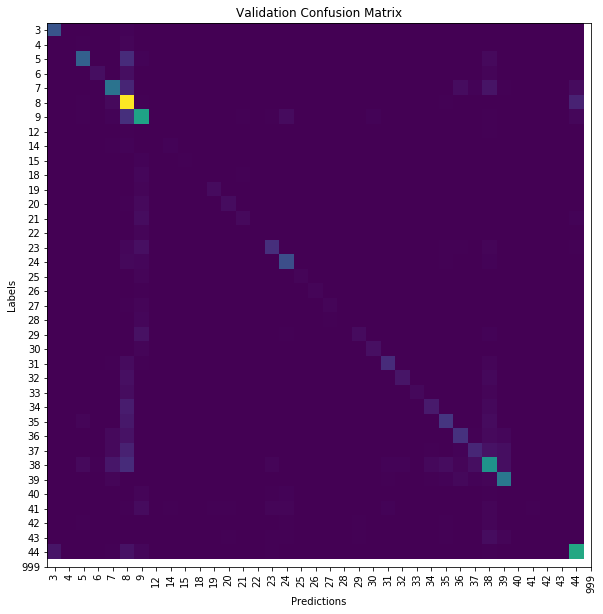

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(cmat);

_ = ax.set_xticks(np.arange(len(model.classes_)))
_ = ax.set_yticks(np.arange(len(model.classes_)))
              
_ = ax.set_xticklabels(model.classes_, rotation=90)
_ = ax.set_yticklabels(model.classes_)

plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.title('Validation Confusion Matrix')

We should also look at the weights for each feature.

In [94]:
model.coef_.shape

(38, 68)

**Question**: Shouldn't there be as many weights as there are features (68)? Why do we have 38 rows here?

See below for explanation of ovr.

### Changing the loss used by Logistic Regression

At this stage, you should have a reasonable question. Everything we saw about logistic regression referred to the binary classification problem i.e. there were two classes - 0 and 1 and we were trying to classify objects/rows into these two classes. But here we have 38 classes and logistic regression still worked. 

**Question**: look at the documentation for sklearn.linear_model.LogisticRegression and see if you can discover how the model accounts for multiple classes.

LogisticRegression takes a parameter called "multi-class". By default, it takes the value "ovr". (See _check_multi_class in sklearn/linear_model/logistic.py).

"ovr" (one-vs-rest) turns a problem with N classes into N binary classification problems. More concretely, if the N classes are $1, 2, \ldots, N$, then N models will be built. The first one will label class 1 as 1 and everything else as 0. The second model will label class 2 as 1 and everything as 0 and so on. Each model will then be called during inference to predict a score. These scores are then normalized (divide by sum of scores).

Now you can see why we the shape of the coefficients was (38,68). We have 38 logistic regression models!

"multinomial" solves a fundamentally different problem. It optimizes for the loss that is exactly our loss above.

So let's try repeating the procedure above but with "multinormial"

In [95]:
#this might be slow due to max_iter
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(df_train_f1.drop('TripType', axis=1), df_train_f1['TripType'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
train_class_pred = model.predict(df_train_f1.drop('TripType', axis=1))
val_class_pred = model.predict(df_val_f1.drop('TripType', axis=1))

In [97]:
train_acc = np.sum(train_class_pred==df_train_f1['TripType'].tolist()) / df_train_f1.shape[0]
val_acc = np.sum(val_class_pred==df_val_f1['TripType'].tolist()) / df_val_f1.shape[0]

print(f"Train Acc = {train_acc}")
print(f"Val   Acc = {val_acc}")

Train Acc = 0.6653470779602556
Val   Acc = 0.6700114978572175


**Note**: Our accuracy jumped from 61-62% to ~66%. This is a significant improvement just by changing the loss function. In particular, this is a general theme in machine learning. All machine learning problems can be rephrased as numerical optimization problems. What you optimize has a huge impact on performance. There's a translation from business/research-level metrics to a function that is relatively easy to optimize but also captures the salient features of the business/research-level metric.

In [98]:
train_log_loss = log_loss(df_train_f1['TripType'], model.predict_proba(df_train_f1.drop('TripType', axis=1)), eps=1e-15)
val_log_loss = log_loss(df_val_f1['TripType'], model.predict_proba(df_val_f1.drop('TripType', axis=1)), eps=1e-15, labels=model.classes_)

In [99]:
print(f'Train loss = {train_log_loss}')
print(f'Val   loss = {val_log_loss}')

Train loss = 1.1752193826477024
Val   loss = 1.1737080926135646


As expected, directly optimizing the multinomial loss results in a significantly lower value (compared to ~1.47 earlier with ovr). A value of 1.175 would place us at 488 / 1046 on the leaderboard.

### Changing featurization strategies

The most obvious feature we can include is day of week. Since the 7 days are given as strings, how should we encode them? One option is to map each day to an integer.

Monday -> 0

Tuesday -> 1

Wednesday -> 2

and so on.

**Question**: Do you think is a reasonable idea? Why or why not?

**Answer**:

**Question**: Can you imagine any resource issues with one-hot encoding?

**Answer**:

In [100]:
df_train['Weekday'].head(10)

0    Friday
1    Friday
2    Friday
3    Friday
4    Friday
5    Friday
6    Friday
7    Friday
8    Friday
9    Friday
Name: Weekday, dtype: object

In [101]:
pd.get_dummies(df_train['Weekday']).head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


**Question**: What are the implications of this encoding?

**Answer**:

**Question**: Add these one-hot encoded week values to our features.

In [102]:
df_train_f2 = pd.concat([df_train_f1, 
                         pd.get_dummies(df_train[['VisitNumber', 'Weekday']].set_index('VisitNumber'),
                                        prefix='Weekday')], 
                         axis=1)

In [103]:
df_val_f2 = pd.concat([df_val_f1, 
                       pd.get_dummies(df_val[['VisitNumber', 'Weekday']].set_index('VisitNumber'),
                                      prefix='Weekday')], 
                       axis=1)
df_val_f2 = df_val_f2[df_train_f2.columns] #ensure column order is the same

KeyError: "['Weekday_Saturday', 'Weekday_Sunday'] not in index"

**Question**: Debug this issue.

We have a strong hint. The exception is raised when we try re-ordering the columns in df_val_f2 according to the columns in df_train_v2. It seems like there are no columns called "Weekday_Saturday" and "Weekday_Sunday" in df_val.

Yes! Saturday and Sunday are completely missing in val! What about test?

What about train?

The situation with test is even worse. We only have Friday, Saturday and Sunday. 

**Question**: Why could this be bad? How could we fix this?

**Answer**:

Another **lesson**: check the distribution of variables in train, val and test and ensure they are similar.

So let's re-define our validation strategy and create new train, val and test sets.

In [107]:
#clearing some variables

df_train_f1 = None
df_val_f1 = None
df_test_f1 = None

df_train_f2 = None
df_val_f2 = None
df_test_f2 = None

In [108]:
df = pd.read_csv(f'{DATA_PATH}/train.csv')

unique_visit_numbers = df['VisitNumber'].unique()

N_visits = len(unique_visit_numbers)

TRAIN_PERC = 0.80
VAL_PERC = 0.10
TEST_PERC = 0.10

TRAIN_CUTOFF = int(TRAIN_PERC * N_visits)
VAL_CUTOFF = int((TRAIN_PERC + VAL_PERC) * N_visits)

np.random.seed(100) #for reproducibility
np.random.shuffle(unique_visit_numbers) #shuffle visit numbers

#get visit numbers for each set
train_visit_numbers_rnd = unique_visit_numbers[:TRAIN_CUTOFF]
val_visit_numbers_rnd = unique_visit_numbers[TRAIN_CUTOFF:VAL_CUTOFF]
test_visit_numbers_rnd = unique_visit_numbers[VAL_CUTOFF:]

#ensure no overlap
assert(len(set(train_visit_numbers_rnd).intersection(val_visit_numbers_rnd))==0)
assert(len(set(train_visit_numbers_rnd).intersection(test_visit_numbers_rnd))==0)
assert(len(set(val_visit_numbers_rnd).intersection(test_visit_numbers_rnd))==0)

#split datasets by visit numbers
df_train = df[df['VisitNumber'].isin(train_visit_numbers_rnd)]
df_val = df[df['VisitNumber'].isin(val_visit_numbers_rnd)]
df_test = df[df['VisitNumber'].isin(test_visit_numbers_rnd)]

#fill nulls - could do this before splitting
df_train['Upc'].fillna(-1, inplace=True)
df_train['DepartmentDescription'].fillna("-1", inplace=True)
df_train['FinelineNumber'].fillna(-1, inplace=True)

df_val['Upc'].fillna(-1, inplace=True)
df_val['DepartmentDescription'].fillna("-1", inplace=True)
df_val['FinelineNumber'].fillna(-1, inplace=True)

df_test['Upc'].fillna(-1, inplace=True)
df_test['DepartmentDescription'].fillna("-1", inplace=True)
df_test['FinelineNumber'].fillna(-1, inplace=True)

#do department replacement
df_train.loc[df_train['DepartmentDescription']=='HEALTH AND BEAUTY AIDS', 'DepartmentDescription'] = 'BEAUTY'
df_val.loc[df_val['DepartmentDescription']=='HEALTH AND BEAUTY AIDS', 'DepartmentDescription'] = 'BEAUTY'
df_test.loc[df_test['DepartmentDescription']=='HEALTH AND BEAUTY AIDS', 'DepartmentDescription'] = 'BEAUTY'

#persist datasets - "rnd" -> random split
#nonnull -> nulls replaced
#deprep -> department replaced
df_train.reset_index(drop=True).to_feather(f'{DATA_PATH}/df_nonull_deprep_train_rnd.feather')
df_val.reset_index(drop=True).to_feather(f'{DATA_PATH}/df_nonull_deprep_val.feather')
df_test.reset_index(drop=True).to_feather(f'{DATA_PATH}/df_nonull_deprep_test.feather')

df = None

/home/sanjay/anaconda3/envs/fastai2/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/sanjay/anaconda3/envs/fastai2/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


**Question**: Check the distribution of weekday, department description and trip type in train, val and test. Are these similar?

In [3]:
#weekday

We have all the days in each dataset now. The distributions are also similar.

In [4]:
#trip type

You could plot this (remove the trip type 999 point though since the x-axis will get stretched out) to compare the 3 distributions or manually inspect the values. The distributions are roughly the same.

In [5]:
#department description

Note: the above plot is not quite careful enough. I just plotted the % in each department in decreasing order but the order of departments might be permuted between the 3 datasets. 

**Question**: To be careful, map each department to an integer (ensure it's the same mapping in all 3 datasets) and plot percentage vs the integer.

**Question**: Quickly repeat our experiments with the pivot tables (without the weekday column) to see how performance changes with the new strategy?

In [117]:
#note we have already replaced nulls and the department
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

In [118]:
#check counts
(df_train_f1.sum(axis=1) - df_train.groupby('VisitNumber').agg({'ScanCount': np.sum})['ScanCount']).sum()

0.0

In [119]:
#add trip type
df_train_f1 = pd.concat([df_train[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_train_f1], axis=1)
df_val_f1 = pd.concat([df_val[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_val_f1], axis=1)
df_test_f1 = pd.concat([df_test[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_test_f1], axis=1)

In [120]:
print(df_train_f1.shape)
print(df_val_f1.shape)
print(df_test_f1.shape)

(76539, 69)
(9567, 69)
(9568, 69)


In [121]:
#this might be slow due to max_iter
#model = LogisticRegression() #use if too slow
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100, n_jobs=10)
#model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, n_jobs=10)

model.fit(df_train_f1.drop('TripType', axis=1), df_train_f1['TripType'])

train_class_pred = model.predict(df_train_f1.drop('TripType', axis=1))
val_class_pred = model.predict(df_val_f1.drop('TripType', axis=1))

train_acc = np.sum(train_class_pred==df_train_f1['TripType'].tolist()) / df_train_f1.shape[0]
val_acc = np.sum(val_class_pred==df_val_f1['TripType'].tolist()) / df_val_f1.shape[0]

print(f"Train Acc = {train_acc}")
print(f"Val   Acc = {val_acc}")

train_log_loss = log_loss(df_train_f1['TripType'], model.predict_proba(df_train_f1.drop('TripType', axis=1)), eps=1e-15)
val_log_loss = log_loss(df_val_f1['TripType'], model.predict_proba(df_val_f1.drop('TripType', axis=1)), eps=1e-15, labels=model.classes_)

print(f'Train loss = {train_log_loss}')
print(f'Val   loss = {val_log_loss}')

Train Acc = 0.6658435568794994
Val   Acc = 0.664367095223163
Train loss = 1.1757630895926823
Val   loss = 1.2327885366449


**Note**: Overall, our results didn't change much. We went through this exercise to give you a sense of how real data science work proceeds. There are often unexpected changes in direction which require revisiting almost everything that was done. Let's now proceed to add the one-hot encoded weekday to this data.

In [122]:
#some cleanup
model = None
n_distinct = None

In [124]:
df_train_f1 = pd.concat([df_train_f1, 
                         pd.get_dummies(df_train[['VisitNumber', 'Weekday']].drop_duplicates().set_index('VisitNumber'),
                                        prefix='Weekday')], 
                         axis=1)

In [125]:
df_val_f1 = pd.concat([df_val_f1, 
                       pd.get_dummies(df_val[['VisitNumber', 'Weekday']].drop_duplicates().set_index('VisitNumber'),
                                      prefix='Weekday')], 
                       axis=1)
df_val_f1 = df_val_f1[df_train_f1.columns] #ensure column order is the same

In [126]:
df_test_f1 = pd.concat([df_test_f1, 
                        pd.get_dummies(df_test[['VisitNumber', 'Weekday']].drop_duplicates().set_index('VisitNumber'),
                                       prefix='Weekday')], 
                         axis=1)
df_test_f1 = df_test_f1[df_train_f1.columns]

In [127]:
df_train_f1.head()

,TripType,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
8,26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
9,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
10,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
11,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0


In [128]:
print(df_train_f1.shape)
print(df_val_f1.shape)
print(df_test_f1.shape)

(76539, 76)
(9567, 76)
(9568, 76)


In [129]:
len(df_train['VisitNumber'].unique())

76539

At this stage, you might be running out of memory. To make everything run, I am going to pick much smaller subsets of these datasets.

In [130]:
df_train_f1 = df_train_f1.sample(frac=0.20)
df_val_f1 = df_val_f1.sample(frac=0.20)
df_test_f1 = df_test_f1.sample(frac=0.20)

In [131]:
df_train_f1.shape

(15308, 76)

In [132]:
df_joined_train = None
df_joined_val = None
df_joined_test = None

**Question**: Train a logistic regression model on this data. How does it do?

**Development Note**

Whenever you find yourself repeating the same code in multiple cells, it's a very good hint that you should write a generic function for it. In our case, it would be a function that takes in the train and val dataframes, a model instance, trains it and prints out the relevant metrics. The return value would be your trained model.

We'll resist this urge here but you shouldn't.

While this style of prototyping in a notebook can be very useful, it can also get chaotic and hard to maintain after some time. In our opinion, the frictionless way is to work with data science projects is to prototype small pieces in a notebook and move them to stand-alone python modules with generic functions like the one for training mentioned above.

In [133]:
#this might be slow due to max_iter
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100, n_jobs=10)
model.fit(df_train_f1.drop('TripType', axis=1), df_train_f1['TripType'])

train_class_pred = model.predict(df_train_f1.drop('TripType', axis=1))
val_class_pred = model.predict(df_val_f1.drop('TripType', axis=1))

train_acc = np.sum(train_class_pred==df_train_f1['TripType'].tolist()) / df_train_f1.shape[0]
val_acc = np.sum(val_class_pred==df_val_f1['TripType'].tolist()) / df_val_f1.shape[0]

print(f"Train Acc = {train_acc}")
print(f"Val   Acc = {val_acc}")

train_log_loss = log_loss(df_train_f1['TripType'], model.predict_proba(df_train_f1.drop('TripType', axis=1)), eps=1e-15)
val_log_loss = log_loss(df_val_f1['TripType'], model.predict_proba(df_val_f1.drop('TripType', axis=1)), eps=1e-15, labels=model.classes_)

print(f'Train loss = {train_log_loss}')
print(f'Val   loss = {val_log_loss}')

Train Acc = 0.677488894695584
Val   Acc = 0.6299006795608991
Train loss = 1.1178941772006676
Val   loss = 1.3392816835132895


At this stage, it looks like we are starting to overfit. One way to control this is by increasing the $l_2$ penalty, $1/C$.

In [134]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.1, max_iter=1000, n_jobs=10)
model.fit(df_train_f1.drop('TripType', axis=1), df_train_f1['TripType'])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
train_class_pred = model.predict(df_train_f1.drop('TripType', axis=1))
val_class_pred = model.predict(df_val_f1.drop('TripType', axis=1))

train_acc = np.sum(train_class_pred==df_train_f1['TripType'].tolist()) / df_train_f1.shape[0]
val_acc = np.sum(val_class_pred==df_val_f1['TripType'].tolist()) / df_val_f1.shape[0]

print(f"Train Acc = {train_acc}")
print(f"Val   Acc = {val_acc}")

train_log_loss = log_loss(df_train_f1['TripType'], model.predict_proba(df_train_f1.drop('TripType', axis=1)), eps=1e-15)
val_log_loss = log_loss(df_val_f1['TripType'], model.predict_proba(df_val_f1.drop('TripType', axis=1)), eps=1e-15, labels=model.classes_)

print(f'Train loss = {train_log_loss}')
print(f'Val   loss = {val_log_loss}')

Train Acc = 0.6488110791742879
Val   Acc = 0.6189231573444851
Train loss = 1.2593722487935277
Val   loss = 1.3885565929030432


**Normalization**:

Now for the first time, we have a problem that we didn't quite face before. Most of our columns are counts but we have seven columns (weekday one-hot encodings) that are always 0 or 1.

It helps to have all the numbers on the same scale for linear models. 

1) It makes the optimization process much easier

2) It makes it possible to compare the effects of various columns. If the columns are on similar scales, we can just compare the coefficients $w_i$ and rank them by the absolute values $|w_i|$.

The usual way of making the scales the same is to do the following transformation:

$$x \rightarrow \frac{x - \text{mean}(x)}{\text{std}(x)}$$

where:

$x$ = array of numbers (one column in our case)

$\text{mean}(x)$ = mean of the numbers

$\text{std}(x)$ = standard deviation of the numbers

Strictly speaking, the scale is decided just by the standard deviation but it is helpful to subtract the mean so that the values are centered around 0. But before we go ahead, we need to discuss another topic.

**Leakage**:

Leakage is a general term for information from the validation set and the test set passing into the training process. We discussed earlier that we should set aside the validation and test set and train just on our training set. But there are still subtle ways in which information can pass from the hold-out (val, test) sets into the train set.

**Why is this bad?** Some information, say from the val set, leaking into your train set might improve your model's performance on the val set. So the process that we rely on to estimate how our model will do in real-life is broken - we are getting better results than we would if we actually used our model on new data.

**What is an example of leakage?** In our example, we need to compute the mean and standard deviation of each column and carry out the procedure. The mean and standard deviation should be computed **just on the train set**. In other words, we should split the data and then calculate the mean and standard deviation. If, by mistake, one computes the mean and standard deviation before splitting, then one has leakage.

**Is this really bad?** Not always. Machine learning algorithms make a fundamental assumption that the (statistical) properties of the train set, the val set, and any future data the model sees, are the same. If they are not, your model's performance will most likely severely degrade. If you build a model to classify apples as sellable and not sellable and suddenly you start showing pictures of strawberries, then your model will not be nearly as performant as it was before. On the other hand, if your hold-out set, your train set and your new data will essentially have the same distributions, then this leakage will have no effect.

**Does this mean the val and test set are essentially non-inputs to my model?** Not quite and this is where one has to be careful. Suppose, you are predicting sentiments on pieces of text. You want to create one column for each unique word and a piece of text is featurized by the counts of each word in that piece of text. This is called bag-of-words. This will usually be a very sparse matrix (just like our case above). Now, it is possible that you'll encounter words in the val or test set that you didn't seen in the train set. You could create a special column for unknown words during training or you could look at all the words including those in val and test and create columns for them. Of course, during training, you never see some of those words and those columns will always be 0 so not really helpful during your training process but this is not technically leakage.

A couple of more realistic examples:

1. Suppose your data consists of time-series (numbers indexed by time - stock prices etc.). You decide to featurize them by choosing some histogram bins and counting the number of entries in your time-series in each bin. Looking at all the data to choose the bins is also not leakage. You can think of this as a continuous (as opposed to discrete) version of the word problem above. Of course, if there are bins that are only occupied by the val or test set, then that column will be completely constant (= 0) during the train set and not very helpful but usually that won't happen.

2. While working with language - say sentiment analysis again, you can completely ignore the labels (positive or negative sentiment) and use all the text to build a language model. A language model is a machine learning model that predicts the next word (or character) given the previous history (these are mostly neural network models today). As long as you don't use the labels somehow, this is a completely reasonable thing to do. The language model then is used to map a piece of text to features which are used to predict the sentiment (at this stage, the labels come back in and we follow the usual practice of splitting into train, val and test).

**Takeaway**: Whenever confronted with an ideological truth, it is useful to probe it to understand when exactly it is true and when it is not. Leakage is a severe problem and one should be very careful about it but being ideological about it can lead one to ignore valuable statistical power that you could gain from other sources (like the language model example above).

**Next step**: We'll use sklearn's in-built scaling module to the standard scaling and then build our model.

In [136]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)

#separate features and target
df_train_f1_features = df_train_f1.drop('TripType', axis=1)
df_val_f1_features = df_val_f1.drop('TripType', axis=1)
df_test_f1_features = df_test_f1.drop('TripType', axis=1)

df_train_f1_target = df_train_f1['TripType']
df_val_f1_target = df_val_f1['TripType']
df_test_f1_target = df_test_f1['TripType']

df_train_f1_scaled = scaler.fit_transform(df_train_f1_features)
df_val_f1_scaled = scaler.transform(df_val_f1_features)
df_test_f1_scaled = scaler.transform(df_test_f1_features)

#these are not pandas dataframes so re-convent to pd.DataFrame
df_train_f1_scaled = pd.DataFrame(df_train_f1_scaled, columns=df_train_f1_features.columns, index=df_train_f1_features.index)
df_val_f1_scaled = pd.DataFrame(df_val_f1_scaled, columns=df_val_f1_features.columns, index=df_val_f1_features.index)
df_test_f1_scaled = pd.DataFrame(df_test_f1_scaled, columns=df_test_f1_features.columns, index=df_test_f1_features.index)

df_train_f1_scaled['TripType'] = df_train_f1_target
df_val_f1_scaled['TripType'] = df_val_f1_target
df_test_f1_scaled['TripType'] = df_test_f1_target

In [137]:
df_train_f1_scaled.head()

,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,TOYS,WIRELESS,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,TripType
VisitNumber,,,,,,,,,,,,,,,,,,,,,
113209,-0.069305,-0.035445,-0.082904,-0.122625,-0.216191,-0.100362,-0.21037,-0.087352,-0.069066,-0.086672,...,-0.137631,-0.094354,-0.436618,-0.387109,-0.463699,-0.463283,-0.364120,2.683142,-0.363775,8
36101,-0.069305,-0.035445,-0.082904,-0.122625,-0.216191,-0.100362,-0.21037,-0.087352,-0.069066,-0.086672,...,-0.137631,-0.094354,-0.436618,-0.387109,-0.463699,-0.463283,-0.364120,-0.372697,2.748952,37
116469,-0.069305,-0.035445,-0.082904,-0.122625,-0.216191,-0.100362,-0.21037,-0.087352,-0.069066,-0.086672,...,-0.137631,-0.094354,-0.436618,-0.387109,-0.463699,-0.463283,-0.364120,2.683142,-0.363775,25
104766,-0.069305,-0.035445,-0.082904,-0.122625,-0.216191,-0.100362,-0.21037,-0.087352,-0.069066,-0.086672,...,-0.137631,-0.094354,-0.436618,-0.387109,-0.463699,2.158506,-0.364120,-0.372697,-0.363775,9
128647,-0.069305,-0.035445,-0.082904,-0.122625,2.289070,-0.100362,-0.21037,-0.087352,-0.069066,-0.086672,...,-0.137631,-0.094354,-0.436618,-0.387109,-0.463699,-0.463283,2.746345,-0.372697,-0.363775,39


**Question**: Train a model on our scaled dataframe.

In [6]:
def train_model(model, df_train, df_val):
    #fill this
    
    return model

In [139]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100, n_jobs=10)

model = train_model(model, df_train_f1_scaled, df_val_f1_scaled)

Train Acc = 0.6797099555787823
Val   Acc = 0.628855201254574
Train loss = 1.0856633017191628
Val   loss = 1.379200048574205


At this stage, there are many directions we can go in. One is to inspect the statistical properties of the data in more detail. For example, we can look at the pairwise correlations between our features. Ideally, we want these to be as uncorrelated as possible. Correlated features giving misleading coefficients that are much harder to interpret. As an example, suppose we had two features: height in meters and height in centimeters. Our prediction would be:

$$\sigma(C + w_1 h_m + w_2 h_{cm})$$

Now, of course we know that $h_m = 100 * h_{cm}$! We have the same information but the linear model has no idea and finds some values for $w_1, w_2$. But we have an infinite family of possibilities:

$$w_{*} h_m = (w_1 + 0.01 * w_2) h_{m}$$

where $w_{*}$ is the actual weight in the process that generated the data. We could choose any $w_1,w_2$ that lie on the straight line:

$$w_1 + 0.01 * w_2 = w_{*}$$

and out predictions wouldn't change. But our interpretation would definitely change. We might thing either $w_1$ is far more important or $w_2$ is far more important.


**Question**: Compute the correlation matrix of the features.

In [140]:
corr_matrix = #fill this

Text(0.5, 1.0, 'Validation Confusion Matrix')

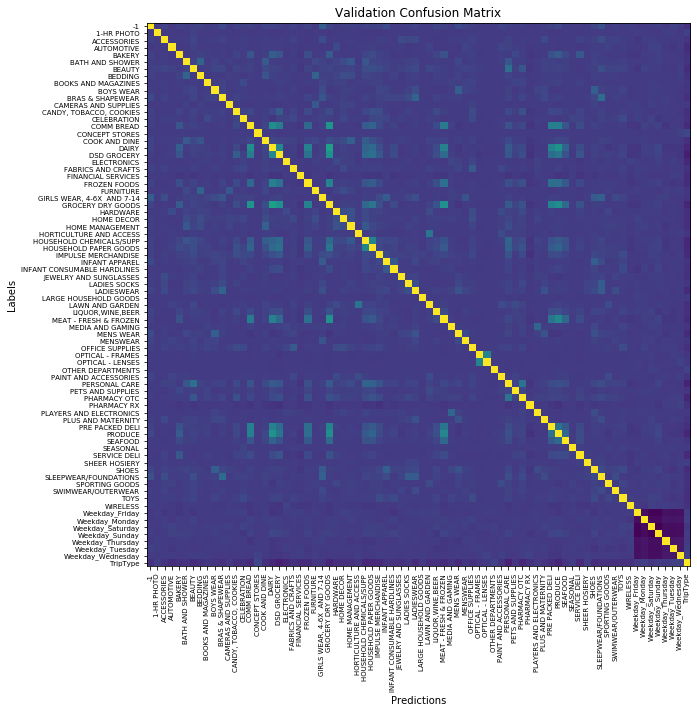

In [141]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(corr_matrix);

_ = ax.set_xticks(np.arange(corr_matrix.shape[0]))
_ = ax.set_yticks(np.arange(corr_matrix.shape[1]))
              
_ = ax.set_xticklabels(corr_matrix.columns, rotation=90, fontsize=7)
_ = ax.set_yticklabels(corr_matrix.index, fontsize=7)

plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.title('Validation Confusion Matrix')

In [142]:
import operator

sorted(list(corr_matrix.loc['BATH AND SHOWER'].abs().items()), key=operator.itemgetter(1), reverse=True)

[('BATH AND SHOWER', 1.0),
 ('BEDDING', 0.17158077977161507),
 ('COOK AND DINE', 0.12325308984160209),
 ('HOME MANAGEMENT', 0.12038272996419044),
 ('PERSONAL CARE', 0.1122758627704174),
 ('HOUSEHOLD CHEMICALS/SUPP', 0.10536518505141484),
 ('HOME DECOR', 0.06215745857718217),
 ('FURNITURE', 0.05194912754410026),
 ('MENS WEAR', 0.043537029649473286),
 ('HOUSEHOLD PAPER GOODS', 0.04110532731722823),
 ('SHOES', 0.03390259034245458),
 ('BEAUTY', 0.0336578597102724),
 ('LADIESWEAR', 0.03361233360606211),
 ('TripType', 0.033290963390224554),
 ('HARDWARE', 0.03169067182102822),
 ('IMPULSE MERCHANDISE', 0.03137792965868969),
 ('PLUS AND MATERNITY', 0.02441923608459174),
 ('PRE PACKED DELI', 0.021984104185579178),
 ('BOYS WEAR', 0.019922639865794855),
 ('GIRLS WEAR, 4-6X  AND 7-14', 0.01972878766249545),
 ('LADIES SOCKS', 0.019695705065985128),
 ('TOYS', 0.017428008825713107),
 ('CAMERAS AND SUPPLIES', 0.015937494521156642),
 ('COMM BREAD', 0.01568997620028415),
 ('SEAFOOD', 0.01520074336440177)

We didn't discuss this in class but one technique for "disentangling" correlated features is called principal component analysis (PCA). Essentially, we find linear combinations of features such that they are uncorrelated. Mathematically, we compute the covariance matrix of the features and diagonalize it (find eigenvectors and eigenvalues). The eigenvectors tell us the weights of the linear combinations and the eigenvalues tell us the variance of each combination.

Don't worry about the details here except that before you do PCA, you should zero-mean the data (which we did for the scaled dataframes).

In [143]:
from sklearn.decomposition import PCA

In [144]:
pca = PCA()
pca.fit(df_train_f1_scaled.drop('TripType', axis=1))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

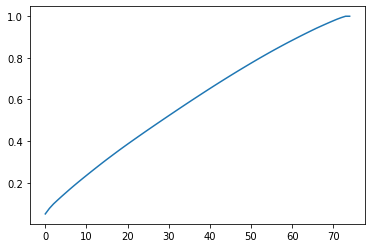

In [145]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [146]:
#the first component explains 0.05 = 5% of the variance
pca.explained_variance_ratio_[0]

0.04994186404392267

In [147]:
list(zip(df_train_f1_scaled.drop('TripType', axis=1).columns, pca.components_[0]))

[('-1', 0.038001414228164256),
 ('1-HR PHOTO', -0.013113376682534428),
 ('ACCESSORIES', 0.0031910113310085197),
 ('AUTOMOTIVE', 0.0022871994012924057),
 ('BAKERY', 0.12485423518278116),
 ('BATH AND SHOWER', 0.03694193834696028),
 ('BEAUTY', 0.06354253588829771),
 ('BEDDING', 0.026290618250197812),
 ('BOOKS AND MAGAZINES', 0.018268442202883723),
 ('BOYS WEAR', 0.002319199486128955),
 ('BRAS & SHAPEWEAR', 0.029598309098793088),
 ('CAMERAS AND SUPPLIES', -0.008186941952591623),
 ('CANDY, TOBACCO, COOKIES', 0.07938765025127163),
 ('CELEBRATION', 0.010178538734073766),
 ('COMM BREAD', 0.3086452903650086),
 ('CONCEPT STORES', -0.006357266546883234),
 ('COOK AND DINE', 0.07144331606412258),
 ('DAIRY', 0.35821956031774543),
 ('DSD GROCERY', 0.30057325157149845),
 ('ELECTRONICS', -0.002223726773853805),
 ('FABRICS AND CRAFTS', 0.012185126879096763),
 ('FINANCIAL SERVICES', -0.03323020605618879),
 ('FROZEN FOODS', 0.2547469794453089),
 ('FURNITURE', 5.872818268712109e-05),
 ('GIRLS WEAR, 4-6X  A

Let's try transforming the data to PCA components and training a new model.

In [148]:
df_train_pca = pd.DataFrame(pca.transform(df_train_f1_scaled.drop('TripType', axis=1)), 
                            columns = df_train_f1_features.columns,
                            index = df_train_f1_features.index)
df_train_pca['TripType'] = df_train_f1_scaled['TripType']

df_val_pca = pd.DataFrame(pca.transform(df_val_f1_scaled.drop('TripType', axis=1)), 
                          columns = df_val_f1_features.columns,
                          index = df_val_f1_features.index)
df_val_pca['TripType'] = df_val_f1_scaled['TripType']

df_test_pca = pd.DataFrame(pca.transform(df_test_f1_scaled.drop('TripType', axis=1)), 
                           columns = df_test_f1_features.columns,
                           index = df_test_f1_features.index)
df_test_pca['TripType'] = df_test_f1_scaled['TripType']

In [149]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100, n_jobs=10)

model = train_model(model, df_train_pca, df_val_pca)

Train Acc = 0.6797099555787823
Val   Acc = 0.628855201254574
Train loss = 1.085663301704708
Val   loss = 1.37920004599472


### Conclusion:

At this stage, we won't go deeper into linear regression. The main focus at this stage should be on feature engineering. What if you used Upc or Finelinenumber? What if you combined similar departments into one category? What if, instead of one-hot encoding, you had a scheme for replacing each day -> some number? What could the number be (see target encoding)? 

Instead, as a last demonstration, let's take a look the total number of items bought in each trip.

In [168]:
total_train_counts = df_train.groupby('VisitNumber').agg({'ScanCount': np.sum})['ScanCount']

In [169]:
total_train_counts

VisitNumber
5         -1
8         28
9          3
10         3
11         4
          ..
191343     9
191344     5
191345    17
191346    17
191347     2
Name: ScanCount, Length: 76539, dtype: int64

In [170]:
print(total_train_counts.min())

-52


That doesn't look right. Is there a visit with 52 returns?!

In [171]:
total_train_counts[total_train_counts==total_train_counts.min()]

VisitNumber
27471   -52
Name: ScanCount, dtype: int64

In [172]:
df_train[df_train['VisitNumber']==27471]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
95346,999,27471,Tuesday,7.128786e+09,-1,COOK AND DINE,378.0
95347,999,27471,Tuesday,7.644091e+09,-1,COOK AND DINE,3609.0
95348,999,27471,Tuesday,7.128786e+09,-1,COOK AND DINE,378.0
95349,999,27471,Tuesday,7.128786e+09,-1,COOK AND DINE,378.0
95350,999,27471,Tuesday,4.704666e+09,-1,PHARMACY OTC,713.0
95351,999,27471,Tuesday,7.931900e+10,-1,PHARMACY OTC,713.0
95352,999,27471,Tuesday,7.447102e+09,-2,GROCERY DRY GOODS,3302.0
95353,999,27471,Tuesday,7.128786e+09,-1,COOK AND DINE,378.0
95354,999,27471,Tuesday,2.120057e+09,-1,HOUSEHOLD CHEMICALS/SUPP,9530.0
95355,999,27471,Tuesday,1.117265e+09,-1,COOK AND DINE,514.0


In [173]:
df_train[df_train['VisitNumber']==27471].groupby('DepartmentDescription').sum()['ScanCount']

DepartmentDescription
ACCESSORIES                 -1
COOK AND DINE              -14
GROCERY DRY GOODS          -10
HOUSEHOLD CHEMICALS/SUPP    -2
IMPULSE MERCHANDISE         -2
LADIESWEAR                  -1
LAWN AND GARDEN             -3
PERSONAL CARE               -1
PHARMACY OTC               -17
SWIMWEAR/OUTERWEAR          -1
Name: ScanCount, dtype: int64

Well actually there **IS** such a trip

**Question**: Are there any trips where the total number of items bought is 0? That would be trouble.

**Question**: How many such trips are there? Why do these trips show up in our dataset?!

Wow! we have ~1400 trips where the total count of all items bought is 0. This means one of two things - either nothing was bought (then why is there a trip in our data) or what's more likely is that these trips had some returns too. Let's check

In [176]:
total0_visits = total_train_counts[total_train_counts==0].index

In [177]:
df_train[df_train['VisitNumber'].isin(total0_visits)].groupby('VisitNumber').agg({'ScanCount': lambda x: np.sum(np.abs(x))}).sort_values(by='ScanCount')['ScanCount'].value_counts()

2     1091
4      216
6       64
8       40
10       9
12       8
16       4
30       2
22       2
20       2
18       2
14       2
Name: ScanCount, dtype: int64

Let's look at the trip types for these visits.

In [178]:
df_train[df_train['VisitNumber'].isin(total0_visits)][['VisitNumber', 'TripType']].drop_duplicates()['TripType'].value_counts()

999    1441
8         1
Name: TripType, dtype: int64

That's very interesting. Are we to infer that if there's a single return, then the trip is mostly like "999" (other)

In [179]:
df_train[df_train['ScanCount']<0]['ScanCount'].unique()

array([ -1,  -2,  -3,  -4,  -5,  -6,  -7,  -9, -10])

In [180]:
df_train[df_train['ScanCount']<0][['TripType', 'VisitNumber']].drop_duplicates()['TripType'].value_counts()

999    5168
40      746
39      496
37      226
9       226
8       211
25      201
7       159
38      148
36      131
42      125
24      113
44       96
32       86
5        80
35       66
33       61
15       45
22       44
41       38
43       37
6        36
3        36
27       35
20       34
34       33
30       29
18       25
28       24
21       23
29       21
31       21
26       18
19       14
12       14
23        8
4         7
14        1
Name: TripType, dtype: int64

In [181]:
len(df_train[df_train['ScanCount']<0]['VisitNumber'].unique())

8882

**Point 1**: If we look at all the trips that have even one single return, then the vast majority are of type 999. The actual fraction is: 

$$\frac{5168}{8882} \approx 58\%$$

**Point 2**: If we look at all the trips where **the total sum of items = 0** (this is a strict subset of the visits considered in point 1), then 

$$\frac{1440}{1441} \approx 100\%$$

of the trips are of type 999!

We could reate a rule. Always check the total "ScanCount" of a trip. If it's equal to 0, assign its trip type to 999, otherwise use our model. We also have to remove all such rows from our dataset.

I am also curious to see what actually causes one of the rows to be assigned the trip type 8. Let's inspect those two rows to see if something pops out.

In [182]:
df_train[(df_train['VisitNumber'].isin(total0_visits)) & (df_train['TripType']==8)]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
321206,8,96445,Saturday,9506.0,1,DSD GROCERY,9225.0
321207,8,96445,Saturday,9506.0,-1,DSD GROCERY,9225.0


The only reasonable guess is that there's something in the type of product bought.

In [183]:
df_train[(df_train['VisitNumber'].isin(total0_visits)) & (df_train['TripType']==999)]['DepartmentDescription'].value_counts()

IMPULSE MERCHANDISE      387
MENS WEAR                196
DSD GROCERY              183
FINANCIAL SERVICES       162
PERSONAL CARE            138
                        ... 
MENSWEAR                   6
OPTICAL - FRAMES           6
SHEER HOSIERY              5
SEAFOOD                    4
MEAT - FRESH & FROZEN      2
Name: DepartmentDescription, Length: 62, dtype: int64

We see "DSD Grocery" here. Maybe it's the FinelineNumber

In [184]:
df_train[(df_train['VisitNumber'].isin(total0_visits)) & (df_train['TripType']==999)]['FinelineNumber'].value_counts().loc[9225]

10

It's quite rare but still present. Maybe the Upc?

In [185]:
df_train[(df_train['VisitNumber'].isin(total0_visits)) & (df_train['TripType']==999)]['Upc'].value_counts().loc[9506]

2

Even the product Upc shows up. At this stage, I wouldn't manually spend more effort trying to understand this.

Overall, we spent some time exploring our data, building some linear models and trying out different featurizations. Tomorrow, we'll turn this process around a bit. We'll start with a tree-based model and look into the model to understand our data.